# 🚗 Used Car Price Prediction — Professional Notebook
**Author:** Abdullah Naseem  
**Date:** 2025-08-18  

This notebook builds a professional, end‑to‑end **Used Car Price Prediction** pipeline using the popular Craigslist used‑car dataset.

### What you'll learn/do
- Define a clear **business problem** and success metrics (MAE/RMSE/R²).
- Acquire data from **Kaggle** (Colab‑friendly).
- Perform robust **EDA** and **data cleaning**.
- Engineer **features** (age, mileage per year, encodings).
- Train and compare **regression models** (Linear/Ridge, RandomForest, XGBoost/LightGBM).
- Add **explainability** with SHAP.
- Save a **production‑style pipeline** for inference.


## 1) Business Framing

**Problem:** Sellers often misprice used cars, causing slow sales or lost margin.  
**Goal:** Predict a fair market price given car attributes (year, mileage, brand, model, condition, etc.).  
**Primary Metric:** **MAE** (Mean Absolute Error) — easy to interpret in currency.  
**Secondary Metrics:** RMSE (penalizes large errors), R² (variance explained).  

**Deliverables:**
- Clean EDA and model comparison.
- Saved pipeline for inference (`.joblib`).
- Explainability visuals (what drives price).

**Constraints & Notes:**
- The dataset has **real listings**; it may be messy. We’ll filter out obvious outliers and handle missing data.
- For categorical variables with many unique values (e.g., `model`), we’ll use **target encoding** to avoid exploding one‑hot dimensions.


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
# If running in Google Colab, uncomment the next line to upgrade pip first.
%pip install -q --upgrade pip

# Core scientific stack & modeling libs
%pip install -q numpy pandas scikit-learn xgboost lightgbm catboost shap category-encoders pyarrow fastparquet plotly kaleido

# Optional: Kaggle / opendatasets for convenient data download
%pip install -q kaggle opendatasets

import os, sys, warnings, json, zipfile, glob, math, textwrap, joblib
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import shap
import category_encoders as ce

print('Environment ready')

Environment ready


## 2) Environment Setup




Upload your kaggle.json from Kaggle
and move it into place

In [ ]:
# === Kaggle API Setup ===
# Upload your kaggle.json file when prompted.
from google.colab import files
files.upload()

# Move kaggle.json to the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Test Kaggle is working (optional)
!kaggle datasets list -s cars


Saving kaggle.json to kaggle.json
ref                                                           title                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
austinreese/craigslist-carstrucks-data                        Used Cars Dataset                  275237598  2021-05-06 17:14:08.443000         103305       1560  1.0              
doaaalsenani/usa-cers-dataset                                 US Cars Dataset                        67478  2020-04-22 14:38:05.453000          41262        407  1.0              
abdulmalik1518/cars-datasets-2025                             Cars Datasets (2025)                   25987  2025-07-17 21:43:28.493000          14425        299  1.0              
thedevastator/uncovering-factors-that-affect-used-car-prices  Used

In [ ]:
# === OPTION A) Kaggle API

from pathlib import Path
Path('/root/.kaggle').mkdir(parents=True, exist_ok=True)

if Path('/content/kaggle.json').exists():
    !mv /content/kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

# Download the dataset (will create a ZIP in the working dir)
!kaggle datasets download -d austinreese/craigslist-carstrucks-data -p ./data -q
!mkdir -p data && unzip -q -o ./data/craigslist-carstrucks-data.zip -d ./data

print('Files in ./data:')
!ls -lh ./data | sed -n '1,120p'

Dataset URL: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data
License(s): CC0-1.0
Files in ./data:
total 1.7G
-rw-r--r-- 1 root root 263M May  6  2021 craigslist-carstrucks-data.zip
-rw-r--r-- 1 root root 1.4G May  6  2021 vehicles.csv


## 3) Data Acquisition (Kaggle → Colab)

We'll use the **Craigslist Used Cars** dataset by *Austin Reese* on Kaggle, which contains real vehicle listings across the U.S. (columns like price, year, odometer, manufacturer, model, fuel, transmission, etc.).

**Dataset page:** `austinreese/craigslist-carstrucks-data`

>  **Kaggle API** — upload your `kaggle.json` (Account → Create API Token)


## 4) Load Data (Memory‑Aware)

We’ll load **only the columns we need** initially to keep RAM usage friendly.  
Common columns in this dataset include:

- `price, year, manufacturer, model, condition, cylinders, fuel, odometer, title_status, transmission, drive, size, type, paint_color, state, region, lat, long`

We’ll also:  
- Remove obviously invalid records (e.g., price ≤ 500 or > 150,000, negative/zero mileage).  
- Create derived features like **age** and **mileage_per_year**.


In [ ]:
import pandas as pd, numpy as np, glob, os, math
from pathlib import Path

# Try to find a CSV inside ./data
csv_candidates = glob.glob('data/*.csv') + glob.glob('data/*/*.csv') + glob.glob('data/*.tsv')
if not csv_candidates:
    raise SystemExit(' No CSV found in ./data. Make sure the Kaggle download succeeded.')

csv_path = csv_candidates[0]
print('Reading:', csv_path)

usecols = [
    'price','year','manufacturer','model','condition','cylinders','fuel','odometer',
    'title_status','transmission','drive','size','type','paint_color','state','region',
    'lat','long'
]

# Set dtypes for memory efficiency where safe
dtype_map = {
    'price':'float32',
    'year':'float32',
    'odometer':'float32',
    'cylinders':'category',
    'fuel':'category',
    'condition':'category',
    'manufacturer':'category',
    'model':'category',
    'title_status':'category',
    'transmission':'category',
    'drive':'category',
    'size':'category',
    'type':'category',
    'paint_color':'category',
    'state':'category',
    'region':'category'
}

df = pd.read_csv(csv_path, usecols=[c for c in usecols if c in pd.read_csv(csv_path, nrows=1).columns],
                 dtype=dtype_map, low_memory=False)

print('Shape (raw):', df.shape)
df.head(3)

Reading: data/vehicles.csv
Shape (raw): (426880, 18)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,prescott,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN
1,fayetteville,11900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN
2,florida keys,21000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN


Check missing values

In [ ]:
df.isnull().mean().sort_values(ascending=False)[:10]


,0
size,0.717675
cylinders,0.416225
condition,0.407852
drive,0.305863
paint_color,0.305011
type,0.217527
manufacturer,0.041337
title_status,0.019308
long,0.015342
lat,0.015342


## 5) Basic Cleaning & Sanity Filters

We’ll apply lightweight cleaning rules to remove impossible or extreme values that can harm model training:

- Keep prices within a reasonable bracket (e.g., USD **$500 to $150,000**).
- Keep `year` between **1990** and **current_year**.
- Keep `odometer` > 0 and below an upper bound (e.g., **1,000,000 km/mi**).
- Drop rows with missing `price`, `year`, or `odometer`.


In [ ]:
import pandas as pd
from datetime import datetime

current_year = datetime.now().year

# Drop NAs for key columns
df = df.dropna(subset=['price','year','odometer'])

# Basic filters
df = df[(df['price'] >= 500) & (df['price'] <= 150000)]
df = df[(df['year'] >= 1990) & (df['year'] <= current_year + 1)]
df = df[(df['odometer'] > 0) & (df['odometer'] < 1_000_000)]

# Derived features
df['age'] = (current_year - df['year']).clip(lower=0)
df['mileage_per_year'] = (df['odometer'] / df['age'].replace(0, np.nan)).fillna(df['odometer'])

print('Shape (clean):', df.shape)
df[['price','year','odometer','age','mileage_per_year']].describe().T

Shape (clean): (368379, 20)


,count,mean,std,min,25%,50%,75%,max
price,368379.0,19347.669922,14717.278320,500.000000,7900.0,15990.000000,27990.000000,150000.00
year,368379.0,2012.265991,5.926724,1990.000000,2009.0,2013.000000,2017.000000,2022.00
odometer,368379.0,94980.960938,69387.796875,1.000000,39253.0,89000.000000,137050.000000,999999.00
age,368379.0,12.733783,5.832633,3.000000,8.0,12.000000,16.000000,35.00
mileage_per_year,368379.0,7217.933105,4820.841309,0.028571,4248.0,6937.700195,9533.333008,249999.75


## 6) Exploratory Data Analysis (EDA)

We’ll inspect distributions and relationships:
- **Price distribution** (raw vs. log).
- **Price vs. year**, **price vs. odometer**.
- Average price by **manufacturer** (top 20).


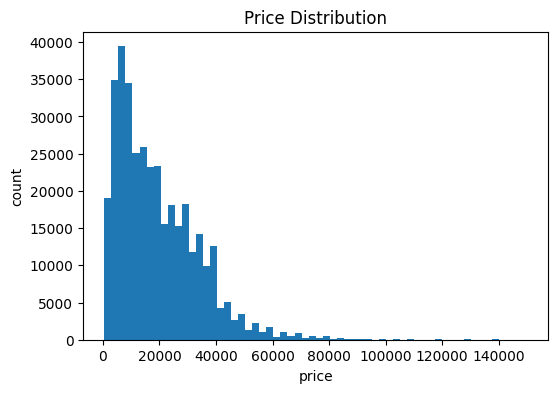

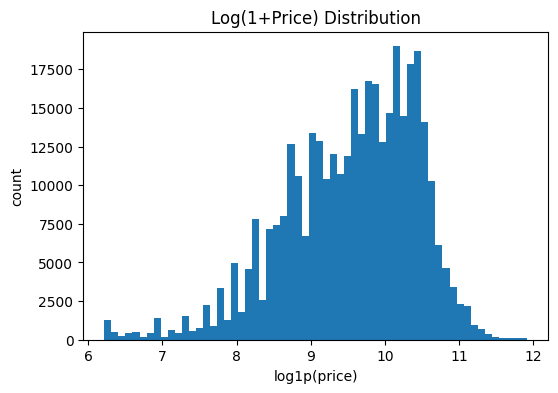

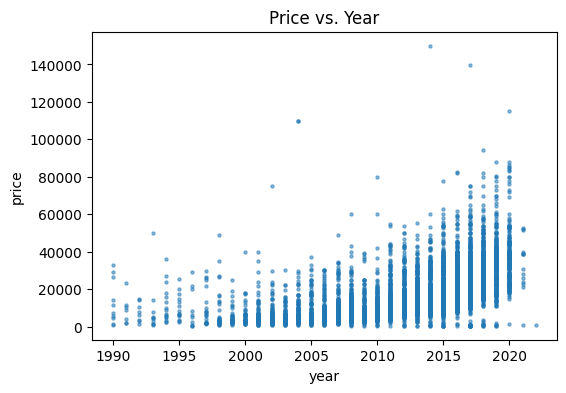

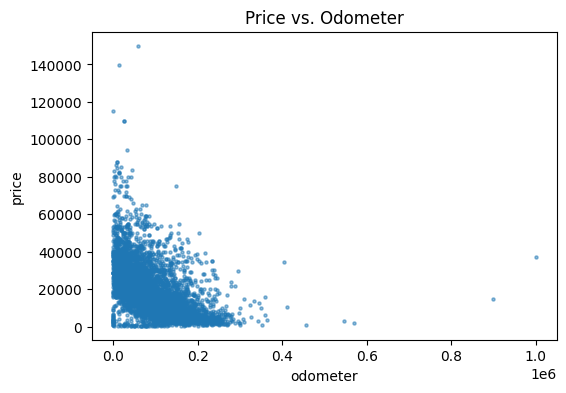

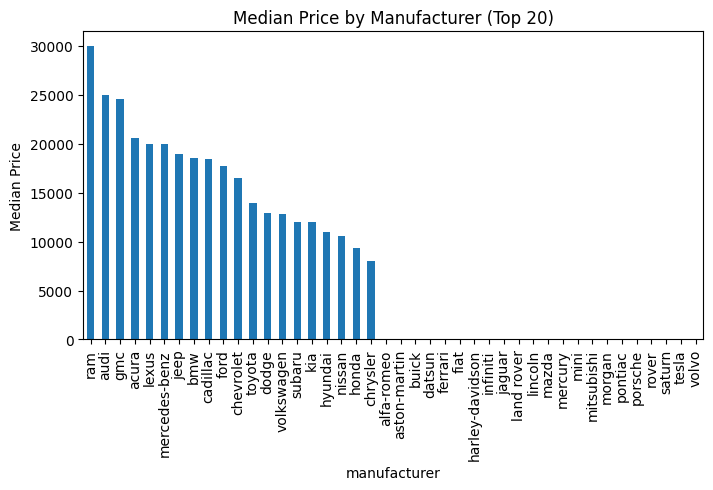

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Price histograms
fig = plt.figure(figsize=(6,4))
plt.hist(df['price'], bins=60)
plt.title('Price Distribution')
plt.xlabel('price')
plt.ylabel('count')
plt.show()

fig = plt.figure(figsize=(6,4))
plt.hist(np.log1p(df['price']), bins=60)
plt.title('Log(1+Price) Distribution')
plt.xlabel('log1p(price)')
plt.ylabel('count')
plt.show()

# Price vs. year / odometer (sample for speed)
samp = df.sample(min(5000, len(df)), random_state=42)
fig = plt.figure(figsize=(6,4))
plt.scatter(samp['year'], samp['price'], s=5, alpha=0.5)
plt.title('Price vs. Year')
plt.xlabel('year'); plt.ylabel('price')
plt.show()

fig = plt.figure(figsize=(6,4))
plt.scatter(samp['odometer'], samp['price'], s=5, alpha=0.5)
plt.title('Price vs. Odometer')
plt.xlabel('odometer'); plt.ylabel('price')
plt.show()

# Top manufacturers
if 'manufacturer' in df.columns:
    top_mf = df['manufacturer'].value_counts().head(20).index
    mf_price = df[df['manufacturer'].isin(top_mf)].groupby('manufacturer')['price'].median().sort_values(ascending=False)
    mf_price.plot(kind='bar', figsize=(8,4), title='Median Price by Manufacturer (Top 20)')
    plt.ylabel('Median Price')
    plt.show()

## 7) Train/Test Split & Feature Sets

We’ll define features and split data into **train** and **test**.  
To keep the model efficient and interpretable, we’ll separate **low‑cardinality** vs **high‑cardinality** categorical features:
- **Low-cardinality**: one‑hot encode (e.g., `fuel`, `transmission`, `condition`, `drive`, `type`, `state`).
- **High-cardinality** (e.g., `manufacturer`, `model`, `region`): **target encoding**.

We’ll predict **log(price)** for stability and convert back when reporting.


In [ ]:
from sklearn.model_selection import train_test_split

target = 'price'
y = np.log1p(df[target])

# Choose feature candidates that exist in the loaded dataframe
num_features = [c for c in ['year','odometer','age','mileage_per_year'] if c in df.columns]
low_card_cat = [c for c in ['fuel','transmission','condition','drive','type','state','title_status','cylinders','size','paint_color'] if c in df.columns]
high_card_cat = [c for c in ['manufacturer','model','region'] if c in df.columns]

X = df[num_features + low_card_cat + high_card_cat].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)


(294703, 73676)

## 8) Preprocessing Pipelines

- **Numeric:** pass‑through (optionally scale for linear models).  
- **Low‑cardinality categorical:** **OneHotEncoder** (ignore unknowns).  
- **High‑cardinality categorical:** **TargetEncoder** (mean target encoding with CV to reduce leakage).


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    # Trees don't need scaling; you can add StandardScaler for linear models.
])

lowcat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

highcat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', ce.TargetEncoder(handle_missing='value', handle_unknown='value', smoothing=0.3, min_samples_leaf=20, return_df=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('lowcat', lowcat_transformer, low_card_cat),
        ('highcat', highcat_transformer, high_card_cat),
    ],
    remainder='drop'
)

print('Numeric:', num_features)
print('Low-card cat:', low_card_cat)
print('High-card cat:', high_card_cat)


Numeric: ['year', 'odometer', 'age', 'mileage_per_year']
Low-card cat: ['fuel', 'transmission', 'condition', 'drive', 'type', 'state', 'title_status', 'cylinders', 'size', 'paint_color']
High-card cat: ['manufacturer', 'model', 'region']


## 9) Model Candidates & Cross‑Validation

We’ll compare several models using **5‑fold CV** on the training set:

- Linear Regression (baseline on transformed features)
- Ridge Regression
- Random Forest Regressor
- XGBoost Regressor
- LightGBM Regressor

**Scoring:** Negative MAE and Negative RMSE (scikit‑learn uses negative values for loss metrics).  
We’ll report the **mean** across folds for a fair comparison.


In [ ]:
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

# Custom scorers for cross-validation
scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)

scorer_rmse = make_scorer(
    lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
    greater_is_better=False
)


In [ ]:
# Smaller dataset for testing
X_train_small = X_train.sample(50000, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

cv = KFold(n_splits=3, shuffle=True, random_state=42)

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=5.0, random_state=42),
    'RandomForest': RandomForestRegressor(
        n_estimators=100, max_depth=20, n_jobs=-1, random_state=42),
    'XGBRegressor': xgb.XGBRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        objective='reg:squarederror', n_jobs=-1, random_state=42),
    'LGBMRegressor': lgb.LGBMRegressor(
        n_estimators=200, max_depth=20, num_leaves=31, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42)
}

cv_results = []
for name, model in models.items():
    pipe = Pipeline(steps=[('prep', preprocessor), ('model', model)])
    mae_scores = cross_val_score(pipe, X_train_small, y_train_small,
                                 cv=cv, scoring=scorer_mae, n_jobs=-1)
    rmse_scores = cross_val_score(pipe, X_train_small, y_train_small,
                                  cv=cv, scoring=scorer_rmse, n_jobs=-1)
    cv_results.append({
        'model': name,
        'MAE (log-price)': -mae_scores.mean(),
        'RMSE (log-price)': -rmse_scores.mean()
    })

cv_df = pd.DataFrame(cv_results).sort_values(by='MAE (log-price)')
cv_df


,model,MAE (log-price),RMSE (log-price)
2,RandomForest,0.256188,0.443310
4,LGBMRegressor,0.262253,0.444831
3,XGBRegressor,0.262267,0.442556
1,Ridge,0.333395,0.527384
0,LinearRegression,0.333396,0.527352


## 10) Fit Best Model & Evaluate on Holdout Test Set

We’ll select the strongest model from CV (often a gradient boosting tree), fit on the **full training set**, and evaluate on **X_test, y_test**.

We trained on **log(price)**, so we’ll exponentiate predictions to get $$\hat{price} = \exp(\hat{\log(1+price)}) - 1$$.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Best model from Step 9 output: RandomForest
best_model = RandomForestRegressor(random_state=42)

# Build pipeline with preprocessing + best model
best_pipe = Pipeline(steps=[('prep', preprocessor), ('model', best_model)])
best_pipe.fit(X_train, y_train)

# Predict (log price) and invert transform for reporting
y_pred = best_pipe.predict(X_test)
y_pred = np.exp(y_pred) - 1
y_true = np.exp(y_test) - 1

# Evaluation metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae_val = mean_absolute_error(y_true, y_pred)
rmse_val = rmse(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Best model: RandomForest")
print(f"Test MAE: {mae_val:.2f}")
print(f"Test RMSE: {rmse_val:.2f}")
print(f"Test R²: {r2:.4f}")


Best model: RandomForest
Test MAE: 2089.09
Test RMSE: 5035.19
Test R²: 0.8827


## 11) Explainability with SHAP

We’ll compute **SHAP values** for the fitted model (works best with tree‑based models).  
This shows which features push the price prediction up or down **globally** and **per‑row**.


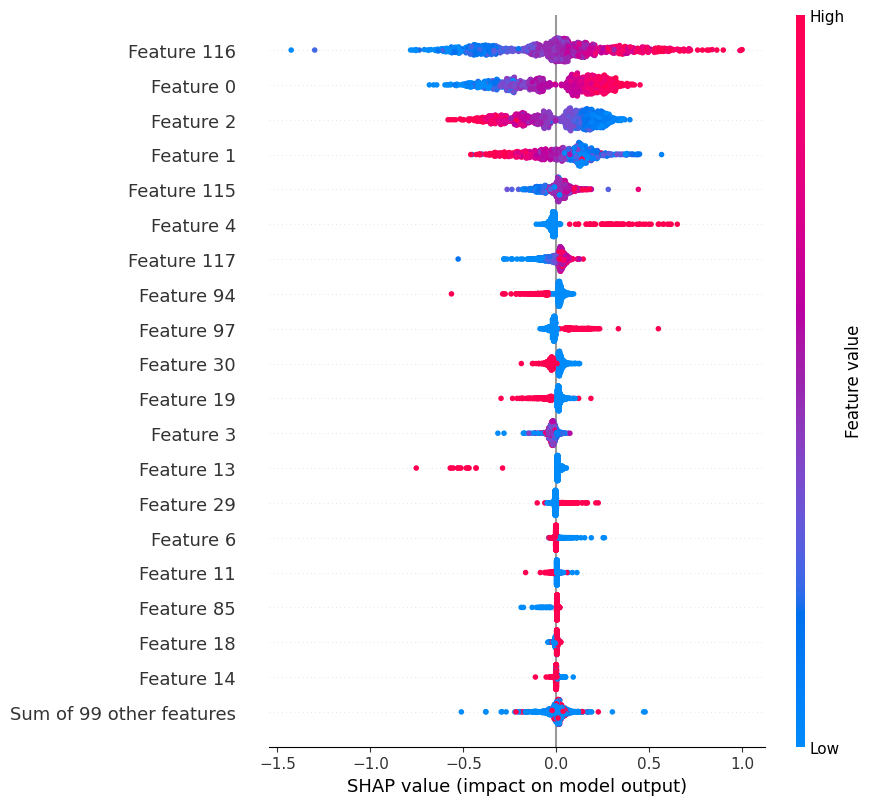

In [ ]:
import shap
# Transform a sample through the preprocessor to get the final feature matrix
X_test_sample = X_test.sample(min(1000, len(X_test)), random_state=42)
X_test_transformed = best_pipe.named_steps['prep'].transform(X_test_sample)

# SHAP for tree models
explainer = shap.Explainer(best_pipe.named_steps['model'])
shap_values = explainer(X_test_transformed)

# Summary plot (may open in a separate output in some environments)
shap.plots.beeswarm(shap_values, max_display=20)

## 12) Save the Trained Pipeline for Reuse

We’ll save the full **preprocessing + model** pipeline so it can be reused in a Streamlit app or API without repeating the feature engineering code.


In [ ]:
import joblib
from pathlib import Path

Path('models').mkdir(exist_ok=True, parents=True)
model_path = 'models/used_car_pricing_pipeline.joblib'
joblib.dump(best_pipe, model_path)
model_path


'models/used_car_pricing_pipeline.joblib'

## 13) Single‑Car Inference Helper

Use this helper to predict a price for any single listing (e.g., power your app).  
Provide values for the available features; missing keys will be handled by imputers.


In [ ]:
def predict_price_single(pipeline, sample_dict):
    # Build single‑row DataFrame with all known feature columns
    cols = num_features + low_card_cat + high_card_cat
    x = pd.DataFrame([sample_dict], columns=cols)
    y_log = pipeline.predict(x)[0]
    y_hat = float(np.expm1(y_log))
    return y_hat

# Example (edit values according to your dataset's categories)
example = {
    'year': 2016,
    'odometer': 65000,
    'age': None,  # will be ignored; we didn't add computation here for single row
    'mileage_per_year': None,
    'manufacturer': 'toyota',
    'model': 'camry',
    'condition': 'good',
    'cylinders': '4 cylinders',
    'fuel': 'gas',
    'title_status': 'clean',
    'transmission': 'automatic',
    'drive': 'fwd',
    'size': np.nan,
    'type': 'sedan',
    'paint_color': 'white',
    'state': 'ca',
    'region': 'los angeles'
}

# Derive missing engineered fields if possible
if example.get('age') is None and example.get('year') is not None:
    from datetime import datetime
    example['age'] = max(0, datetime.now().year - example['year'])
if example.get('mileage_per_year') is None and example.get('odometer') is not None and example.get('age') is not None:
    example['mileage_per_year'] = example['odometer'] / (example['age'] or 1)

pred = predict_price_single(best_pipe, example)
print(f'Predicted price for example listing: ${pred:,.0f}')

Predicted price for example listing: $12,865


In [ ]:
import joblib
joblib.dump(best_pipe, "car_price_model.pkl")


['car_price_model.pkl']

In [ ]:
import pickle

classes_used = []

with open("car_price_model.pkl", "rb") as f:
    u = pickle._Unpickler(f)

    def fake_find_class(module, name):
        full = f"{module}.{name}"
        classes_used.append(full)
        return object   # return a harmless dummy type so unpickling continues

    u.find_class = fake_find_class
    try:
        u.load()
    except Exception as e:
        print("Stopped unpickling early:", e)

# Show first 30 unique classes
print("=== Classes referenced in pickle file ===")
for c in sorted(set(classes_used))[:30]:
    print(c)

print(f"\nTotal classes found: {len(set(classes_used))}")


Stopped unpickling early: 'object' object has no attribute '__dict__'
=== Classes referenced in pickle file ===
sklearn.compose._column_transformer.ColumnTransformer
sklearn.impute._base.SimpleImputer
sklearn.pipeline.Pipeline

Total classes found: 3


In [ ]:
import joblib
model = joblib.load("car_price_model.pkl")
print("Model loaded successfully:", type(model))


Model loaded successfully: <class 'sklearn.pipeline.Pipeline'>


In [ ]:
import joblib
joblib.dump(model, "car_price_model_v2.pkl")


['car_price_model_v2.pkl']

In [ ]:
model = joblib.load("car_price_model_v2.pkl")


In [10]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajaabdullah313","key":"f9d6a4e7c39d7d57949a98ae5ad77b4a"}'}

In [11]:
!mkdir -p ~/.kaggle

In [12]:
!cp kaggle.json ~/.kaggle/

In [13]:
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets list -s cars | head -n 20


ref                                                           title                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
austinreese/craigslist-carstrucks-data                        Used Cars Dataset                  275237598  2021-05-06 17:14:08.443000         103849       1564  1.0              
doaaalsenani/usa-cers-dataset                                 US Cars Dataset                        67478  2020-04-22 14:38:05.453000          41373        407  1.0              
abdulmalik1518/cars-datasets-2025                             Cars Datasets (2025)                   25987  2025-07-17 21:43:28.493000          18056        337  1.0              
thedevastator/uncovering-factors-that-affect-used-car-prices  Used Cars                           19

In [15]:
!mkdir -p ./data

In [16]:

# Download dataset from Kaggle
!kaggle datasets download -d austinreese/craigslist-carstrucks-data -p ./data

Dataset URL: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data
License(s): CC0-1.0
 99% 261M/262M [00:00<00:00, 417MB/s]
100% 262M/262M [00:00<00:00, 479MB/s]


In [17]:
# Unzip dataset
!unzip -q -o ./data/craigslist-carstrucks-data.zip -d ./data

In [18]:
!ls -lh ./data | head -n 20

total 1.7G
-rw-r--r-- 1 root root 263M May  6  2021 craigslist-carstrucks-data.zip
-rw-r--r-- 1 root root 1.4G May  6  2021 vehicles.csv


In [19]:
import pandas as pd

csv_path = "./data/vehicles.csv"   # the file you saw
usecols = [
    'price','year','manufacturer','model','condition','cylinders','fuel','odometer',
    'title_status','transmission','drive','size','type','paint_color','state','region',
    'lat','long'
]

# Load with memory-friendly dtypes
dtype_map = {
    'price':'float32',
    'year':'float32',
    'odometer':'float32',
    'cylinders':'category',
    'fuel':'category',
    'condition':'category',
    'manufacturer':'category',
    'model':'category',
    'title_status':'category',
    'transmission':'category',
    'drive':'category',
    'size':'category',
    'type':'category',
    'paint_color':'category',
    'state':'category',
    'region':'category'
}

df = pd.read_csv(csv_path, usecols=usecols, dtype=dtype_map, low_memory=False)

print("Shape:", df.shape)
df.head(3)


Shape: (426880, 18)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,prescott,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN
1,fayetteville,11900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN
2,florida keys,21000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN


In [20]:
import joblib

# Pick only categorical columns for dropdowns
categorical_cols = [
    "manufacturer","condition","cylinders","fuel","title_status",
    "transmission","drive","size","type","paint_color","state","region"
]

# Collect unique values for dropdowns
dropdown_values = {}
for col in categorical_cols:
    dropdown_values[col] = sorted(df[col].dropna().unique().tolist())

# Save dropdown values for later use in app.py
joblib.dump(dropdown_values, "dropdown_values.pkl")
print("✅ Saved dropdown_values.pkl with", len(dropdown_values), "columns")


✅ Saved dropdown_values.pkl with 12 columns


In [22]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# ---------------------------
# Select features + target
# ---------------------------
X = df[[
    "year","odometer","manufacturer","condition","cylinders",
    "fuel","title_status","transmission","drive","size","type",
    "paint_color","state","region"
]]
y = df["price"]

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Save trained model
joblib.dump(model, "model.pkl")
print("✅ Model saved as model.pkl")


✅ Model saved as model.pkl


In [23]:
from google.colab import files
files.download("model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 14) Results Summary & Next Steps

**What we did**
- Loaded real used‑car data and applied sanity filters.
- Engineered features (age, mileage per year).
- Compared linear and tree‑based regressors via 5‑fold CV.
- Selected the best model and evaluated on a holdout test set.
- Explained predictions with SHAP.
- Saved a reusable pipeline for deployment.

**What to try next (portfolio boosters)**
- Add a **Streamlit app** to let users input car details and see predicted price + SHAP factors.
- Add a **“similar listings”** panel (nearest neighbors in feature space).
- Experiment with **CatBoost** (native categorical handling) and **hyperparameter tuning** (Optuna).
- Add a **model card** documenting data source, limitations, and fairness considerations.

**Reproducibility**
- Set random seeds for CV; results may vary slightly per dataset version.
- Document your environment in `requirements.txt` (export via `pip freeze > requirements.txt`).

---

> **Data Source:** Kaggle — *Used Cars Dataset (Craigslist Cars & Trucks)* by Austin Reese (`austinreese/craigslist-carstrucks-data`).